# asd_a1_processing

@author: David Clemens-Sewall

Notebook for converting the raw ASD data into the level a1 product. For each site-day that was measured, the following steps are applied:
 1. Gather all relevant information for each measurement, including:
   + SALVO index:
     - timestamp_akdt - from gps log
     - site - from subdirectory name
     - location - from filename
     - position - from albedo file
     - repetition - from albedo file
     - wavelength - from albedo file
     - variable - see below
   + incident_solar_counts - from albedo file
   + reflected_solar_counts - from albedo file
   + latitude - from gps log
   + longitude - from gps log
 2. Compute derived quantities:
   + albedo - ratio of reflected to incident. The timestamp is the timestamp of the reflected.
   + asd_time_diff_s - the time difference between reflected and incident measurements. The timestamp is from the reflected.
   + asd_quality_flag - numeric value for each wavelength indicating ASD data quality. For the a1 product, all values are set to 0.0 (no quality assessment).
 3. Combine all values into a single dataframe in long format using the standard SALVO index (timestamp_akdt 	site 	location 	position 	repetition 	wavelength 	variable). For variables that apply to an entire scan (e.g., 'lat'), there is just a single entry whose wavelength is NaN.
 4. Write that dataframe to an hdf5 file in the a1 directory
   

In [67]:
import os
import re
import glob
import pandas as pd
import numpy as np
from openpyxl import load_workbook

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [68]:
# Data paths
raw_path = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'raw')
# Get all day-sites that we have data for
in_dirs = [subdir for subdir in os.listdir(raw_path) if re.match(r"[0-9]{8}", subdir)]

out_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a1')

In [69]:
def convert_to_a1(albedo_filepath, gps_filepath, site_name):
    """
    Reads in the provided albedo and gpslog files and converts them into a1 formatted albedo
    
    parameters:
    -----------
    albedo_filepath: path-like
        path to the raw albedo file xlsx file
    gps_filepath: path-like
        path to the raw gps log file
    site_name: str
        site name ('arm', 'beo', or 'ice')
    
    returns:
    --------
    pandas DataFrame with albedo data indexed according to SALVO conventions
    
    """
    
    ### Parse albedo file
    ws = load_workbook(albedo_filepath, read_only=True, data_only=True)['Template']
    ## Get header and scannumber rows
    # Get positions
    for value in ws.iter_rows(min_row=3, max_row=3, min_col=48, values_only=True):
        pos_row = list(value)
    # duplicate position values because only incident positions are written
    for i in range(len(pos_row)//2):
        pos_row[2*i+1] = pos_row[2*i]
    # Get I/R row
    for value in ws.iter_rows(min_row=4, max_row=4, min_col=48, values_only=True):
        ir_row = list(value)
    # Get scannumber row
    for value in ws.iter_rows(min_row=5, max_row=5, min_col=48, values_only=True):
        sn_row = list(value)
    # Crop end of lists where scan number row is None
    for last_ind in range(len(sn_row))[::-1]:
        if sn_row[last_ind] is not None:
            last_ind += 1
            break
    pos_row = pos_row[:last_ind]
    ir_row = ir_row[:last_ind]
    sn_row = sn_row[:last_ind]
    ## Get data
    data = np.zeros((2151, last_ind))
    for i, value in zip(np.arange(2151), 
                        ws.iter_rows(min_row=6, max_row=2156, min_col=48, max_col=48+last_ind-1, values_only=True)):
        data[i,:] = value
    ## Wavelength index (fixed)
    wv_ind = range(350, 2501)
    
    ### Parse GPS log
    df_gps = pd.read_csv(gps_filepath, names=
                         ['timestamp_raw', 'scan_path', 'raw_lat', 'raw_NS', 'raw_lon', 'raw_EW'],
                        usecols=[0, 1, 4, 5, 6, 7])
    ## Convert lat lon to decimal degrees
    # Check that all raw_NS are 'N'
    if not ((df_gps.raw_NS == 'N') | df_gps.raw_NS.isna()).all():
        print('Error in gps NS')
    # Check that all raw_EW are 'W'
    if not ((df_gps.raw_EW == 'W') | df_gps.raw_EW.isna()).all():
        print('Error in gps EW')
    # The gps lat/lon format is essentially degrees decimal minutes, 
    # with no space between degrees and minutes
    df_gps['lat'] = df_gps.raw_lat//100 + round(df_gps.raw_lat%100/60.0, 7)
    df_gps['lon']= -1*(df_gps.raw_lon//100 + round(df_gps.raw_lon%100/60.0, 7))
    ## Add timezone to timestamps and convert to datetime
    df_gps['timestamp_akdt'] = pd.to_datetime(df_gps['timestamp_raw'] + '-0800', format='%m/%d/%Y %I:%M:%S %p%z')
    ## Extract filenames
    df_gps['sn'] = df_gps['scan_path'].apply(os.path.basename)
    
    ### Construct albedo dataframe
    df_alb = pd.DataFrame(data=data.T, index=sn_row, columns=wv_ind)
    df_alb['position'] = pos_row
    df_alb['variable'] = ['incident_solar_counts' if ir=='I' else 'reflected_solar_counts' for ir in ir_row]
    df_alb = df_alb.join(df_gps[['sn', 'timestamp_akdt']].set_index('sn'), how='left')
    df_alb['site'] = site_name
    df_alb['location'] = 'line'
    df_alb['repetition'] = 1.0
    df_alb_lon = df_alb.melt(id_vars=['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'variable'],
                 var_name='wavelength')
    # Create albedo values
    df_piv = df_alb_lon[['position', 'wavelength', 'variable', 'value']
            ].set_index(['position', 'wavelength']).pivot(columns='variable', values='value')
    s_alb = df_piv['reflected_solar_counts'] / df_piv['incident_solar_counts']
    s_alb.name = 'value'
    df_alb_temp = df_alb_lon[df_alb_lon['variable']=='reflected_solar_counts'][
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength']
        ].set_index(['position', 'wavelength']).join(s_alb)
    df_alb_temp['variable'] = 'albedo'
    df_alb_temp = df_alb_temp.reset_index()
    # Create albedo quality flag field
    df_alb_qual = df_alb_temp.copy()
    df_alb_qual['variable'] = 'asd_quality_flag'
    df_alb_qual['value'] = 0.0
    df_alb_qual = df_alb_qual.reset_index()
    df_alb_qual.drop(columns=['index'], inplace=True)
    
    ### Construct ancillary dataframes
    df_anc = pd.DataFrame(data={'sn': sn_row,
                                'position': pos_row,
                               'variable': ['incident_solar_counts' if ir=='I' else 'reflected_solar_counts' for ir in ir_row]})

    df_anc = df_anc.join(df_gps[['sn', 'timestamp_akdt', 'lat', 'lon']].set_index('sn'), how='left', on='sn')
    ## Create time difference
    df_piv = df_anc[['position', 'variable', 'timestamp_akdt']].pivot(columns='variable', index='position', values='timestamp_akdt')
    sr_td_s = (df_piv['incident_solar_counts'] - df_piv['reflected_solar_counts']).dt.total_seconds()
    sr_td_s.name = 'value'
    # Join to reflected timestamps
    df_td = df_anc[df_anc['variable']=='reflected_solar_counts'][['position', 'timestamp_akdt']].join(sr_td_s, on='position')
    # Add rest of index
    df_td['variable'] = 'asd_time_diff_s'
    df_td['site'] = site_name
    df_td['location'] = 'line'
    df_td['repetition'] = 1.0
    df_td['wavelength'] = np.NaN
    ## Create lat lon dataframe
    df_ll = df_anc[['timestamp_akdt', 'position', 'lat', 'lon']].melt(
        id_vars=['timestamp_akdt', 'position'], var_name='variable')
    df_ll['site'] = site_name
    df_ll['location'] = 'line'
    df_ll['repetition'] = 1.0
    df_ll['wavelength'] = np.NaN
    
    # Create dataframe with all data for export
    # Combine data, time difference, and lat-lon into s singe dataframe
    df_out = pd.concat([df_alb_lon, df_alb_temp, df_alb_qual, df_ll, df_td], ignore_index=True).set_index(
        ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])
    
    return df_out

In [70]:
def handler_convert_to_a1(in_dir, out_dir):
    site_name = in_dir[-3:]

    # Get name of albedo file
    filepaths = glob.glob(os.path.join(raw_path, in_dir, 'salvo*line_asd-albedo*.00.xlsx'))
    if len(filepaths)==1:
        albedo_filepath = filepaths[0]
    else:
        print('No line albedo file for ' + in_dir)
        albedo_filepath = None
        return

    # Get name of gps file
    gps_filepaths = glob.glob(os.path.join(raw_path, in_dir, 'raw', '*gps.log'))
    if len(gps_filepaths)==1:
        gps_filepath = gps_filepaths[0]
    else:
        print('No or multiple gps logs in ' + in_dir)
        gps_filepath = None
        return

    df_out = convert_to_a1(albedo_filepath, gps_filepath, site_name)
    out_name = os.path.basename(albedo_filepath)[:-7] + 'a1.h5'
    df_out.to_hdf(os.path.join(out_dir, out_name), key='data', mode='w', format='table',
                 complevel=9, complib='blosc:lz4')
    print('wrote: '+out_name)
    

In [71]:
handler_convert_to_a1(in_dirs[8], out_dir)

wrote: salvo_arm_line_asd-albedo_20240527.a1.h5


In [56]:
# convert data
for i in range(len(in_dirs)):
    handler_convert_to_a1(in_dirs[i], out_dir)
    print('')

wrote: salvo_ice_line_asd-albedo_20240417.a1.h5

wrote: salvo_arm_line_asd-albedo_20240419.a1.h5

wrote: salvo_beo_line_asd-albedo_20240420.a1.h5

wrote: salvo_ice_line_asd-albedo_20240421.a1.h5

wrote: salvo_beo_line_asd-albedo_20240523.a1.h5

wrote: salvo_arm_line_asd-albedo_20240524.a1.h5

wrote: salvo_arm_line_asd-albedo_20240525.a1.h5

wrote: salvo_ice_line_asd-albedo_20240526.a1.h5

No or multiple gps logs in 20240527-arm

wrote: salvo_arm_line_asd-albedo_20240529.a1.h5

wrote: salvo_beo_line_asd-albedo_20240529.a1.h5

wrote: salvo_ice_line_asd-albedo_20240530.a1.h5

No line albedo file for 20240601-arm

wrote: salvo_beo_line_asd-albedo_20240602.a1.h5

wrote: salvo_arm_line_asd-albedo_20240603.a1.h5

No line albedo file for 20240604-arm

wrote: salvo_ice_line_asd-albedo_20240604.a1.h5

wrote: salvo_arm_line_asd-albedo_20240605.a1.h5

wrote: salvo_beo_line_asd-albedo_20240605.a1.h5

wrote: salvo_arm_line_asd-albedo_20240606.a1.h5

wrote: salvo_ice_line_asd-albedo_20240607.a1.h5

w

## Below here is scratchwork (not needed for converting data to a1).

In [57]:
in_dir = in_dirs[23]
site_name = in_dir[-3:]

# Get name of albedo file
filepaths = glob.glob(os.path.join(raw_path, in_dir, 'salvo*line_asd-albedo*.00.xlsx'))
if len(filepaths)==1:
    albedo_filepath = filepaths[0]
else:
    print('No line albedo file for ' + in_dir)
    albedo_filepath = None
    #return

# Get name of gps file
gps_filepaths = glob.glob(os.path.join(raw_path, in_dir, 'raw', '*gps.log'))
if len(gps_filepaths)==1:
    gps_filepath = gps_filepaths[0]
else:
    print('No or multiple gps logs in ' + in_dir)
    gps_filepath = None
    #return

df_out = convert_to_a1(albedo_filepath, gps_filepath, site_name)

In [58]:
df_out

,,,,,,,value
timestamp_akdt,site,location,position,repetition,wavelength,variable,
2024-06-10 12:08:29-08:00,ice,line,200,1.0,350.0,incident_solar_counts,2857.791721
2024-06-10 12:08:42-08:00,ice,line,200,1.0,350.0,reflected_solar_counts,2252.412925
2024-06-10 12:09:20-08:00,ice,line,195,1.0,350.0,incident_solar_counts,2861.397368
2024-06-10 12:09:35-08:00,ice,line,195,1.0,350.0,reflected_solar_counts,2187.936745
2024-06-10 12:10:00-08:00,ice,line,190,1.0,350.0,incident_solar_counts,2860.868151
...,...,...,...,...,...,...,...
2024-06-10 12:35:56-08:00,ice,line,20,1.0,NaN,asd_time_diff_s,-17.000000
2024-06-10 12:36:37-08:00,ice,line,15,1.0,NaN,asd_time_diff_s,-17.000000
2024-06-10 12:37:25-08:00,ice,line,10,1.0,NaN,asd_time_diff_s,-16.000000


In [59]:
# try writing dataframe to hdf5 file
out_dir = os.path.join('..', '..', 'export', 'final-upload-data', 'spectral_albedo_2024', 'a1')

out_name = os.path.basename(albedo_filepath)[:-7] + 'a1.h5'
df_out.to_hdf(os.path.join(out_dir, out_name), key='data', mode='w', format='table',
             complevel=9, complib='blosc:lz4')

In [60]:
# Try loading it in
df_a1 = pd.read_hdf(os.path.join(out_dir, out_name), mode='r')

In [61]:
df_a1.equals(df_out)

True

Text(0, 0.5, 'albedo')

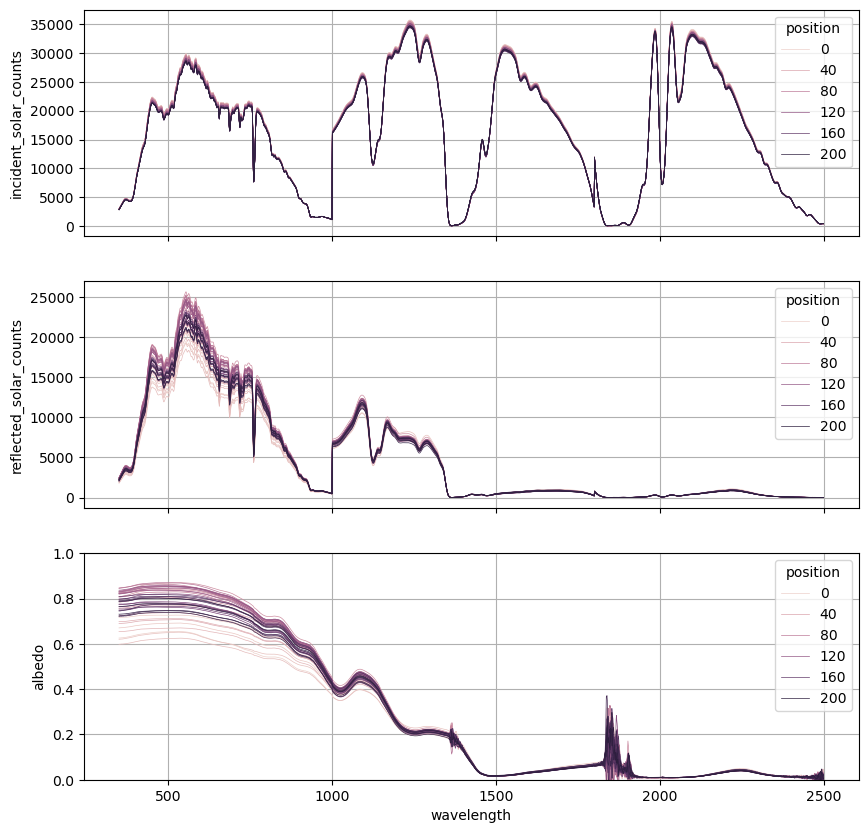

In [62]:
# Check that we can plot things in ways that look reasonable
f, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

variable = 'incident_solar_counts'
df_temp = df_out.query("variable==@variable").reset_index()
sns.lineplot(x='wavelength', y='value', hue='position', data=df_temp,
            ax=axs[0], lw=0.5)
axs[0].grid()
#axs[0].set_ylim([0, 200])
axs[0].set_ylabel(variable)

variable = 'reflected_solar_counts'
df_temp = df_out.query("variable==@variable").reset_index()
sns.lineplot(x='wavelength', y='value', hue='position', data=df_temp,
            ax=axs[1], lw=0.5)
axs[1].grid()
#axs[1].set_ylim([0, 200])
axs[1].set_ylabel(variable)

variable = 'albedo'
df_temp = df_out.query("variable==@variable").reset_index()
sns.lineplot(x='wavelength', y='value', hue='position', data=df_temp,
            ax=axs[2], lw=0.5)
axs[2].grid()
axs[2].set_ylim([0, 1])
axs[2].set_ylabel(variable)

In [66]:
df_out.query('variable=="lat"')

,,,,,,,value
timestamp_akdt,site,location,position,repetition,wavelength,variable,
2024-06-10 12:08:29-08:00,ice,line,200,1.0,NaN,lat,71.348963
2024-06-10 12:08:42-08:00,ice,line,200,1.0,NaN,lat,71.348963
2024-06-10 12:09:20-08:00,ice,line,195,1.0,NaN,lat,71.348975
2024-06-10 12:09:35-08:00,ice,line,195,1.0,NaN,lat,71.348974
2024-06-10 12:10:00-08:00,ice,line,190,1.0,NaN,lat,71.348985
...,...,...,...,...,...,...,...
2024-06-10 12:37:25-08:00,ice,line,10,1.0,NaN,lat,71.349402
2024-06-10 12:38:05-08:00,ice,line,5,1.0,NaN,lat,71.349409
2024-06-10 12:38:18-08:00,ice,line,5,1.0,NaN,lat,71.349409


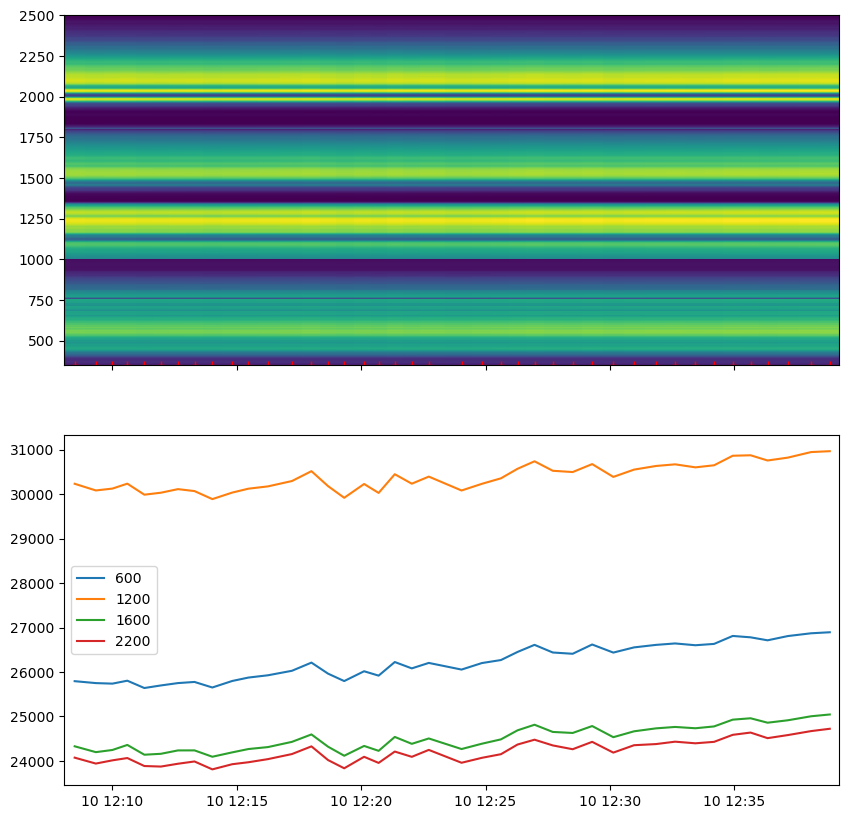

In [64]:
# Try plotting incident over time
f, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
variable = 'incident_solar_counts'
df_temp = df_out.query("variable==@variable").reset_index()[['timestamp_akdt', 'wavelength', 'value']]
df_temp = pd.pivot(df_temp, index='wavelength', columns='timestamp_akdt', values='value')
axs[0].pcolormesh(df_temp.columns.values, df_temp.index.values, df_temp.to_numpy())
axs[0].plot(df_temp.columns.values, np.ones(41)*350, 'r+')

wvs = [600, 1200, 1600, 2200]
axs[1].plot(df_temp.loc[wvs].T)

axs[1].legend(wvs)

In [47]:
in_dir = in_dirs[6]
site_name = in_dir[-3:]

# Get name of albedo file
filepaths = glob.glob(os.path.join(raw_path, in_dir, 'salvo*line_asd-albedo*.00.xlsx'))
if len(filepaths)==1:
    albedo_filepath = filepaths[0]
else:
    print('No line albedo file for ' + in_dir)
    albedo_filepath = None
    #return

# Get name of gps file
gps_filepaths = glob.glob(os.path.join(raw_path, in_dir, 'raw', '*gps.log'))
if len(gps_filepaths)==1:
    gps_filepath = gps_filepaths[0]
else:
    print('No or multiple gps logs in ' + in_dir)
    gps_filepath = None
    #return

In [48]:
### Parse albedo file
albedo_filepath = filepaths[0]
# First we need to get the number of columns in the file
ws = load_workbook(albedo_filepath, read_only=True, data_only=True)['Template']

## Get header and scannumber rows
# Get positions
for value in ws.iter_rows(min_row=3, max_row=3, min_col=48, values_only=True):
    pos_row = list(value)
# duplicate position values because only incident positions are written
for i in range(len(pos_row)//2):
    pos_row[2*i+1] = pos_row[2*i]
# Get I/R row
for value in ws.iter_rows(min_row=4, max_row=4, min_col=48, values_only=True):
    ir_row = list(value)
# Get scannumber row
for value in ws.iter_rows(min_row=5, max_row=5, min_col=48, values_only=True):
    sn_row = list(value)

# Crop end of lists where scan number row is None
for last_ind in range(len(sn_row))[::-1]:
    if sn_row[last_ind] is not None:
        last_ind += 1
        break
pos_row = pos_row[:last_ind]
ir_row = ir_row[:last_ind]
sn_row = sn_row[:last_ind]

## Get data
data = np.zeros((2151, last_ind))
for i, value in zip(np.arange(2151), 
                    ws.iter_rows(min_row=6, max_row=2156, min_col=48, max_col=48+last_ind-1, values_only=True)):
    data[i,:] = value

## Wavelength index (fixed)
wv_ind = range(350, 2501)

## Get sky conditions
sky_con = ws['G2'].value

In [53]:
### Parse GPS log
# Get name of gps log
gps_filepaths = glob.glob(os.path.join(raw_path, in_dir, 'raw', '*gps.log'))
if len(gps_filepaths)==1:
    df_gps = pd.read_csv(gps_filepaths[0], names=
                         ['timestamp_raw', 'scan_path', 'raw_lat', 'raw_NS', 'raw_lon', 'raw_EW'],
                        usecols=[0, 1, 4, 5, 6, 7])
    
    ## Convert lat lon to decimal degrees
    # Check that all raw_NS are 'N'
    if not ((df_gps.raw_NS == 'N') | df_gps.raw_NS.isna()).all():
        print('Error in gps NS')
    # Check that all raw_EW are 'W'
    if not ((df_gps.raw_EW == 'W') | df_gps.raw_EW.isna()).all():
        print('Error in gps EW')
    # The gps lat/lon format is essentially degrees decimal minutes, 
    # with no space between degrees and minutes
    df_gps['lat'] = df_gps.raw_lat//100 + round(df_gps.raw_lat%100/60.0, 7)
    df_gps['lon']= -1*(df_gps.raw_lon//100 + round(df_gps.raw_lon%100/60.0, 7))
    
    ## Add timezone to timestamps and convert to datetime
    df_gps['timestamp_akdt'] = pd.to_datetime(df_gps['timestamp_raw'] + '-0800', format='%m/%d/%Y %I:%M:%S %p%z')
    
    ## Extract filenames
    df_gps['sn'] = df_gps['scan_path'].apply(os.path.basename)
    
else:
    print('No or multiple gps logs in ' + in_dir)

In [54]:
df_gps

,timestamp_raw,scan_path,raw_lat,raw_NS,raw_lon,raw_EW,lat,lon,timestamp_akdt,sn
0,5/25/2024 3:34:08 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.305689,N,15636.693639,W,71.321761,-156.611561,2024-05-25 15:34:08-08:00,SALVO_2024_00477.asd
1,5/25/2024 3:34:17 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.305689,N,15636.693639,W,71.321761,-156.611561,2024-05-25 15:34:17-08:00,SALVO_2024_00478.asd
2,5/25/2024 3:34:47 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.304801,N,15636.700938,W,71.321747,-156.611682,2024-05-25 15:34:47-08:00,SALVO_2024_00479.asd
3,5/25/2024 3:34:55 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.304801,N,15636.700938,W,71.321747,-156.611682,2024-05-25 15:34:55-08:00,SALVO_2024_00480.asd
4,5/25/2024 3:36:10 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.304353,N,15636.711269,W,71.321739,-156.611854,2024-05-25 15:36:10-08:00,SALVO_2024_00481.asd
...,...,...,...,...,...,...,...,...,...,...
82,5/25/2024 3:56:31 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.289471,N,15637.011125,W,71.321491,-156.616852,2024-05-25 15:56:31-08:00,SALVO_2024_00559.asd
83,5/25/2024 3:56:50 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.289127,N,15637.019755,W,71.321485,-156.616996,2024-05-25 15:56:50-08:00,SALVO_2024_00560.asd
84,5/25/2024 3:56:57 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.289127,N,15637.019755,W,71.321485,-156.616996,2024-05-25 15:56:57-08:00,SALVO_2024_00561.asd
85,5/25/2024 3:57:15 PM,C:\Users\ASD User\Desktop\SALVO_2024\SALVO_202...,7119.288003,N,15637.027418,W,71.321467,-156.617124,2024-05-25 15:57:15-08:00,SALVO_2024_00562.asd


In [270]:
### Construct albedo dataframe
df_alb = pd.DataFrame(data=data.T, index=sn_row, columns=wv_ind)
df_alb['position'] = pos_row
df_alb['variable'] = ['incident_solar_counts' if ir=='I' else 'reflected_solar_counts' for ir in ir_row]
df_alb = df_alb.join(df_gps[['sn', 'timestamp_akdt']].set_index('sn'), how='left')
df_alb['site'] = site_name
df_alb['location'] = 'line'
df_alb['repetition'] = 1.0
df_alb_lon = df_alb.melt(id_vars=['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'variable'],
             var_name='wavelength')
# Create albedo values
df_piv = df_alb_lon[['position', 'wavelength', 'variable', 'value']
        ].set_index(['position', 'wavelength']).pivot(columns='variable', values='value')
s_alb = df_piv['reflected_solar_counts'] / df_piv['incident_solar_counts']
s_alb.name = 'value'
df_alb_temp = df_alb_lon[df_alb_lon['variable']=='reflected_solar_counts'][
    ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength']
    ].set_index(['position', 'wavelength']).join(s_alb)
df_alb_temp['variable'] = 'albedo'
# Create albedo quality flag field
df_alb_qual = df_alb_temp.copy()
df_alb_qual['variable'] = 'asd_quality_flag'
df_alb_qual['value'] = 0.0
# Add to dataframe
df_alb_lon = pd.concat([df_alb_lon, df_alb_temp.reset_index(), df_alb_qual.reset_index()])

ValueError: Index contains duplicate entries, cannot reshape

In [280]:
### Construct albedo dataframe
df_alb = pd.DataFrame(data=data.T, index=sn_row, columns=wv_ind)
df_alb['position'] = pos_row
df_alb['variable'] = ['incident_solar_counts' if ir=='I' else 'reflected_solar_counts' for ir in ir_row]
df_alb = df_alb.join(df_gps[['sn', 'timestamp_akdt']].set_index('sn'), how='left')

df_alb

,350,351,352,353,354,355,356,357,358,359,...,2494,2495,2496,2497,2498,2499,2500,position,variable,timestamp_akdt
SALVO_2024_01657.asd,5119.425455,5282.830525,5442.578013,5599.595269,5756.441460,5921.507501,6094.341644,6270.456920,6443.990379,6617.566575,...,66.403117,63.724830,42.870420,44.687105,67.847143,86.555100,108.729473,0,incident_solar_counts,2024-06-07 12:51:56-08:00
SALVO_2024_01657.asd,5119.425455,5282.830525,5442.578013,5599.595269,5756.441460,5921.507501,6094.341644,6270.456920,6443.990379,6617.566575,...,66.403117,63.724830,42.870420,44.687105,67.847143,86.555100,108.729473,0,incident_solar_counts,2024-06-07 16:07:05-08:00
SALVO_2024_01658.asd,3768.310900,3890.228849,4007.993376,4123.666915,4240.452548,4361.571684,4489.881718,4621.813372,4750.990616,4880.264972,...,-33.505185,-29.511756,-26.407819,-10.228526,6.795702,16.240062,40.767890,0,reflected_solar_counts,2024-06-07 12:52:09-08:00
SALVO_2024_01658.asd,3768.310900,3890.228849,4007.993376,4123.666915,4240.452548,4361.571684,4489.881718,4621.813372,4750.990616,4880.264972,...,-33.505185,-29.511756,-26.407819,-10.228526,6.795702,16.240062,40.767890,0,reflected_solar_counts,2024-06-07 16:07:51-08:00
SALVO_2024_01659.asd,5113.698561,5277.218563,5437.712053,5594.842843,5750.553753,5915.653926,6088.731985,6265.120411,6439.014727,6611.385691,...,119.018651,127.947131,126.851005,131.580991,149.643173,149.264667,135.769182,5,incident_solar_counts,2024-06-07 12:52:59-08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SALVO_2024_01734.asd,4801.847701,4957.884257,5109.278790,5257.111254,5403.968716,5555.361993,5716.444734,5883.713348,6048.973686,6210.327283,...,-15.883711,-16.075632,-18.340128,-19.496004,-15.925300,-19.753861,-30.765339,190,reflected_solar_counts,2024-06-07 13:19:20-08:00
SALVO_2024_01735.asd,5898.741240,6090.011378,6276.066109,6457.282404,6636.737981,6823.722195,7020.971317,7224.101329,7425.204707,7624.035556,...,231.041094,235.178992,257.714709,259.369035,248.409068,246.070857,242.715881,195,incident_solar_counts,2024-06-07 13:19:47-08:00
SALVO_2024_01736.asd,4959.609068,5122.014532,5279.202671,5431.914000,5583.479202,5742.231105,5909.671183,6081.494053,6250.966652,6420.713930,...,4.046877,1.286089,-8.924870,-20.101930,-31.704947,-34.573867,-42.308954,195,reflected_solar_counts,2024-06-07 13:19:56-08:00
SALVO_2024_01737.asd,5992.432014,6186.740916,6374.761182,6558.616977,6742.085191,6932.079537,7132.981064,7340.406664,7545.629409,7749.304758,...,272.873366,285.629792,305.113038,305.595082,283.740745,283.394860,287.314470,200,incident_solar_counts,2024-06-07 13:20:22-08:00


In [276]:
pos_row

[0,
 0,
 5,
 5,
 10,
 10,
 15,
 15,
 20,
 20,
 25,
 25,
 30,
 30,
 35,
 35,
 40,
 40,
 45,
 45,
 50,
 50,
 55,
 55,
 60,
 60,
 65,
 65,
 70,
 70,
 75,
 75,
 80,
 80,
 85,
 85,
 90,
 90,
 95,
 95,
 100,
 100,
 105,
 105,
 110,
 110,
 115,
 115,
 120,
 120,
 125,
 125,
 130,
 130,
 135,
 135,
 140,
 140,
 145,
 145,
 150,
 150,
 155,
 155,
 160,
 160,
 165,
 165,
 170,
 170,
 175,
 175,
 180,
 180,
 185,
 185,
 190,
 190,
 195,
 195,
 200,
 200]

In [187]:
### Load notes document
notesname = os.path.basename(filepaths[0]).replace('albedo', 'notes')
df_notes = pd.read_excel(os.path.join(raw_path, in_dir, notesname), 
                         header=0, skiprows=5, usecols=[0, 4, 5], 
                         names=['position', 'surface_type', 'asd_notes'],
                        dtype={'position': int, 'surface_type': str, 'asd_notes': str},
                        keep_default_na=False)

In [248]:
df_alb_lon

,timestamp_akdt,site,location,position,repetition,variable,wavelength,value
0,2024-04-19 14:10:54-08:00,arm,line,0,1.0,incident_solar_counts,350,4039.254489
1,2024-04-19 14:11:20-08:00,arm,line,0,1.0,reflected_solar_counts,350,3706.906630
2,2024-04-19 14:12:20-08:00,arm,line,5,1.0,incident_solar_counts,350,4074.302244
3,2024-04-19 14:12:50-08:00,arm,line,5,1.0,reflected_solar_counts,350,3825.859000
4,2024-04-19 14:13:35-08:00,arm,line,10,1.0,incident_solar_counts,350,4086.215718
...,...,...,...,...,...,...,...,...
88186,2024-04-19 14:51:53-08:00,arm,line,180,1.0,asd_quality_flag,2500,0.000000
88187,2024-04-19 14:52:59-08:00,arm,line,185,1.0,asd_quality_flag,2500,0.000000
88188,2024-04-19 14:54:00-08:00,arm,line,190,1.0,asd_quality_flag,2500,0.000000
88189,2024-04-19 14:54:58-08:00,arm,line,195,1.0,asd_quality_flag,2500,0.000000


In [274]:
df_alb

,350,351,352,353,354,355,356,357,358,359,...,2497,2498,2499,2500,position,variable,timestamp_akdt,site,location,repetition
SALVO_2024_01657.asd,5119.425455,5282.830525,5442.578013,5599.595269,5756.441460,5921.507501,6094.341644,6270.456920,6443.990379,6617.566575,...,44.687105,67.847143,86.555100,108.729473,0,incident_solar_counts,2024-06-07 12:51:56-08:00,ice,line,1.0
SALVO_2024_01657.asd,5119.425455,5282.830525,5442.578013,5599.595269,5756.441460,5921.507501,6094.341644,6270.456920,6443.990379,6617.566575,...,44.687105,67.847143,86.555100,108.729473,0,incident_solar_counts,2024-06-07 16:07:05-08:00,ice,line,1.0
SALVO_2024_01658.asd,3768.310900,3890.228849,4007.993376,4123.666915,4240.452548,4361.571684,4489.881718,4621.813372,4750.990616,4880.264972,...,-10.228526,6.795702,16.240062,40.767890,0,reflected_solar_counts,2024-06-07 12:52:09-08:00,ice,line,1.0
SALVO_2024_01658.asd,3768.310900,3890.228849,4007.993376,4123.666915,4240.452548,4361.571684,4489.881718,4621.813372,4750.990616,4880.264972,...,-10.228526,6.795702,16.240062,40.767890,0,reflected_solar_counts,2024-06-07 16:07:51-08:00,ice,line,1.0
SALVO_2024_01659.asd,5113.698561,5277.218563,5437.712053,5594.842843,5750.553753,5915.653926,6088.731985,6265.120411,6439.014727,6611.385691,...,131.580991,149.643173,149.264667,135.769182,5,incident_solar_counts,2024-06-07 12:52:59-08:00,ice,line,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SALVO_2024_01734.asd,4801.847701,4957.884257,5109.278790,5257.111254,5403.968716,5555.361993,5716.444734,5883.713348,6048.973686,6210.327283,...,-19.496004,-15.925300,-19.753861,-30.765339,190,reflected_solar_counts,2024-06-07 13:19:20-08:00,ice,line,1.0
SALVO_2024_01735.asd,5898.741240,6090.011378,6276.066109,6457.282404,6636.737981,6823.722195,7020.971317,7224.101329,7425.204707,7624.035556,...,259.369035,248.409068,246.070857,242.715881,195,incident_solar_counts,2024-06-07 13:19:47-08:00,ice,line,1.0
SALVO_2024_01736.asd,4959.609068,5122.014532,5279.202671,5431.914000,5583.479202,5742.231105,5909.671183,6081.494053,6250.966652,6420.713930,...,-20.101930,-31.704947,-34.573867,-42.308954,195,reflected_solar_counts,2024-06-07 13:19:56-08:00,ice,line,1.0
SALVO_2024_01737.asd,5992.432014,6186.740916,6374.761182,6558.616977,6742.085191,6932.079537,7132.981064,7340.406664,7545.629409,7749.304758,...,305.595082,283.740745,283.394860,287.314470,200,incident_solar_counts,2024-06-07 13:20:22-08:00,ice,line,1.0


In [243]:
### Construct ancillary dataframes
df_anc = pd.DataFrame(data={'sn': sn_row,
                            'position': pos_row,
                           'variable': ['incident_solar_counts' if ir=='I' else 'reflected_solar_counts' for ir in ir_row]})

df_anc = df_anc.join(df_gps[['sn', 'timestamp_akdt', 'lat', 'lon']].set_index('sn'), how='left', on='sn')

## Create time difference
df_piv = df_anc[['position', 'variable', 'timestamp_akdt']].pivot(columns='variable', index='position', values='timestamp_akdt')
sr_td_s = (df_piv['incident_solar_counts'] - df_piv['reflected_solar_counts']).dt.total_seconds()
sr_td_s.name = 'value'
# Join to incident data
df_td = df_anc[df_anc['variable']=='reflected_solar_counts'][['position', 'timestamp_akdt']].join(sr_td_s, on='position')
# Add rest of index
df_td['variable'] = 'asd_time_diff_s'
df_td['site'] = site_name
df_td['location'] = 'line'
df_td['repetition'] = 1.0
df_td['wavelength'] = np.NaN

## Create lat lon dataframe
df_ll = df_anc[['timestamp_akdt', 'position', 'lat', 'lon']].melt(
    id_vars=['timestamp_akdt', 'position'], var_name='variable')
df_ll['site'] = site_name
df_ll['location'] = 'line'
df_ll['repetition'] = 1.0
df_ll['wavelength'] = np.NaN

In [244]:
# Combine data, time difference, and lat-lon into s singe dataframe
df_out = pd.concat([df_alb_lon, df_ll, df_td], ignore_index=True).set_index(
    ['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength', 'variable'])

In [245]:
df_out

,,,,,,,value
timestamp_akdt,site,location,position,repetition,wavelength,variable,
2024-04-19 14:10:54-08:00,arm,line,0,1.0,350.0,incident_solar_counts,4039.254489
2024-04-19 14:11:20-08:00,arm,line,0,1.0,350.0,reflected_solar_counts,3706.906630
2024-04-19 14:12:20-08:00,arm,line,5,1.0,350.0,incident_solar_counts,4074.302244
2024-04-19 14:12:50-08:00,arm,line,5,1.0,350.0,reflected_solar_counts,3825.859000
2024-04-19 14:13:35-08:00,arm,line,10,1.0,350.0,incident_solar_counts,4086.215718
...,...,...,...,...,...,...,...
2024-04-19 14:51:53-08:00,arm,line,180,1.0,NaN,asd_time_diff_s,-25.000000
2024-04-19 14:52:59-08:00,arm,line,185,1.0,NaN,asd_time_diff_s,-26.000000
2024-04-19 14:54:00-08:00,arm,line,190,1.0,NaN,asd_time_diff_s,-27.000000
